Uses code from notebook provided by Spencer for regridding to lat/lon grid and looking at power spectra.



> Here we follow the methodology of Wheeler and Kiladis (1999) to compute the power spectrum of the symmetric and asymmetric components of the precipitation rate.  Note that we have resampled the precipitation diagnostics to daily temporal resolution and regridded the data to a regular lat-lon grid.

In [1]:
import os
import shutil
import subprocess
import sys
import tempfile

import faceted
import fsspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vcm
import vcm.fv3
import xarray as xr

from vcm import RegionOfInterest
import intake
from vcm.catalog import catalog

grid = catalog["grid/c48"].read()


_KG_M2S_TO_MM_DAY = (1e3 * 86400) / 997.0
fsize=14
from vcm.catalog import catalog
from dask.diagnostics import ProgressBar

sys.path.append("/home/AnnaK/explore/spencerc/2021-10-06-waves")
import spectral_analysis

## Start by regridding fine-resolution, baseline, and ML-corrected precipitation fields

In [13]:
IMAGE = "us.gcr.io/vcm-ml/post_process_run:latest"


def add_fregrid_metadata(ds):
    ds["x"] = ds.x.assign_attrs({"cartesian_axis": "X"})
    ds["y"] = ds.y.assign_attrs({"cartesian_axis": "Y"})
    if "tile" in ds:
        ds = ds.drop("tile")
    return ds


def regrid(url, variable, output):
    subprocess.call(["docker", "image", "pull", IMAGE])
    ds = vcm.fv3.standardize_fv3_diagnostics(xr.open_zarr(fsspec.get_mapper(url)))
    ds = ds[[variable]]    
    ds = add_fregrid_metadata(ds)
    ds = ds.resample(time="6H").mean()

    with tempfile.TemporaryDirectory() as tmpdir:
        input_file = os.path.join(tmpdir, "data_in.nc")
        output_file = os.path.join(tmpdir, "data.nc")        
        docker_in = "/tmp/data_in.nc"
        docker_out = "/tmp/data.nc"

        with ProgressBar():
            ds.to_netcdf(input_file)

        call = [
            "docker",
            "run",
            "-v",
            f"{input_file}:{docker_in}",
            "-v",
            f"{tmpdir}:{docker_out}",
            IMAGE,
            "fregrid_single_input",
            docker_in,
            docker_out,
        ]
        result = subprocess.check_output(call)
        shutil.copyfile(output_file, output)
        return result.decode()

In [14]:
URL = "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-09/decrease-rad-lr-updated-rad-flux-ensemble/fv3gfs_run/diags.zarr"
stdout = regrid(URL, "total_precipitation_rate", os.path.abspath("ml-corrected-precip-6hr.nc"))

[########################################] | 100% Completed | 19.5s


In [15]:
URL = "gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-10/baseline-seaice-prescribed/fv3gfs_run/diags.zarr"
stdout = regrid(URL, "total_precipitation_rate", os.path.abspath("baseline-precip-6hr.nc"))

[########################################] | 100% Completed | 25.7s


In [17]:
UNPERTURBED_FINE_RES = "gs://vcm-ml-intermediate/2021-10-12-PIRE-c48-post-spinup-verification/pire_atmos_phys_3h_coarse.zarr"
stdout = regrid(UNPERTURBED_FINE_RES, "PRATEsfc", os.path.abspath("fine-res-precip-6hr.nc"))

[########################################] | 100% Completed |  4.8s


In [4]:
def seasonal_cycle(x, a1, b1, a2, b2, a3, b3):
    return (
        a1 * np.sin(2 * np.pi * x / 365) + 
        b1 * np.cos(2 * np.pi * x / 365) + 
        a2 * np.sin(4 * np.pi * x / 365) +
        b2 * np.cos(4 * np.pi * x / 365) + 
        a3 * np.sin(6 * np.pi * x / 365) +
        b3 * np.cos(6 * np.pi * x / 365)
    )

In [5]:
def compute_terms(x, labels):
    terms = [
        np.sin(2 * np.pi * x / 365),
        np.cos(2 * np.pi * x / 365),
        np.sin(4 * np.pi * x / 365),
        np.cos(4 * np.pi * x / 365),
        np.sin(6 * np.pi * x / 365),
        np.cos(6 * np.pi * x / 365)
    ]
    return xr.concat(terms, dim=labels)


def remove_first_three_harmonics(da):
    ordinal_time = (da.time - da.time.isel(time=0)) / np.timedelta64(1, "D")
    coefficients = da.curvefit(ordinal_time, seasonal_cycle, reduce_dims=["time"]).curvefit_coefficients
    harmonics = (compute_terms(ordinal_time, coefficients.indexes["param"]) * coefficients).sum("param")
    return da - harmonics

In [6]:
def power_spectrum(da):
    """Assumes frequency of underlying data is six-hourly."""
    deseasonalized = remove_first_three_harmonics(da.sel(latitude=slice(-15, 15)))
    segmented = spectral_analysis.segment(deseasonalized, "time", 96 * 4, 60 * 4)
    detrended = spectral_analysis.xdetrend(segmented, "time")
    windowed = detrended * spectral_analysis.hanning(detrended, "time")
    spectrum = spectral_analysis.space_time_spectrum(
        windowed,
        space_dim="longitude",
        dx=spectral_analysis.sample_spacing(windowed, "longitude"),
        dt=0.25
    )
    result = spectrum.mean("segment")
    result = result.weighted(np.cos(np.deg2rad(result.latitude))).mean("latitude")
    with ProgressBar():
        result = result.compute()
    background = spectral_analysis.red_spectrum(result, {"freq": 10, "wavenumber": 40})
    return result / background

In [7]:
def symmetric_component(da):
    sh = da.isel(latitude=slice(None, da.sizes["latitude"] // 2))
    nh = da.isel(latitude=slice(da.sizes["latitude"] // 2, None)).drop("latitude").isel(latitude=slice(None, None, -1))
    component = (sh + nh) / 2.
    result = xr.concat([component, component.isel(latitude=slice(None, None, -1))], dim="latitude")
    return result.assign_coords(latitude=da.latitude).rename(da.name)


def asymmetric_component(da):
    sh = da.isel(latitude=slice(None, da.sizes["latitude"] // 2))
    nh = da.isel(latitude=slice(da.sizes["latitude"] // 2, None)).drop("latitude").isel(latitude=slice(None, None, -1))
    component = (nh - sh) / 2.
    result = xr.concat([component, component.isel(latitude=slice(None, None, -1))], dim="latitude")
    return result.assign_coords(latitude=da.latitude).rename(da.name)

In [8]:
datasets = {
    "baseline-precip-6hr.nc": "total_precipitation_rate", 
    "fine-res-precip-6hr.nc": "PRATEsfc",
    "ml-corrected-precip-6hr.nc": "total_precipitation_rate"
}

In [9]:
symmetric_spectra = {}
asymmetric_spectra = {}
for dataset, variable in datasets.items():
    da = xr.open_mfdataset(dataset)[variable]
    symmetric = symmetric_component(da)
    asymmetric = asymmetric_component(da)
    symmetric_spectra[dataset] = power_spectrum(symmetric)
    asymmetric_spectra[dataset] = power_spectrum(asymmetric)

[########################################] | 100% Completed |  1min  8.1s
[########################################] | 100% Completed |  1min  5.7s
[########################################] | 100% Completed |  1min  6.0s
[########################################] | 100% Completed |  1min  5.8s
[########################################] | 100% Completed |  1min  6.3s
[########################################] | 100% Completed |  1min  5.3s


In [10]:
PLOT_LABELS = {
    "fine-res-precip-6hr.nc": "Verification",
    "baseline-precip-6hr.nc": "Baseline",
    "ml-corrected-precip-6hr.nc": "ML-corrected"
}

#### Symmetric component of precipitation power spectra

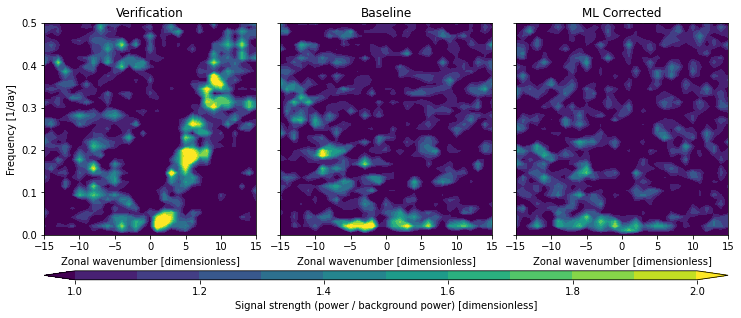

In [12]:
sym = xr.concat(symmetric_spectra.values(), dim=pd.Index(symmetric_spectra.keys(), name="dataset"))

fig, axes, cax = faceted.faceted(1, 3, aspect=1, width=10, cbar_mode="single", cbar_location="bottom")

for ax, dataset in zip(axes, [ "fine-res-precip-6hr.nc", "baseline-precip-6hr.nc", "ml-corrected-precip-6hr.nc",]):
    p = sym.sel(dataset=dataset).plot.contourf(ax=ax, vmin=1., vmax=2, levels=11, x="wavenumber", add_colorbar=False)
    ax.set_xlim([-15, 15])
    ax.set_ylim([0, 0.5])
    ax.set_xlabel("Zonal wavenumber [dimensionless]")
    ax.set_ylabel("")
    ax.set_title(PLOT_LABELS[dataset])
    
axes[0].set_ylabel("Frequency [1/day]")
    
plt.colorbar(p, cax=cax, orientation="horizontal", label="Signal strength (power / background power) [dimensionless]")
fig.savefig("figures/eps/symmetric-precipitation-wheeler-kiladis-diagram.eps", bbox_inches="tight", format="eps")

#### Asymmetric component of precipitation power spectra

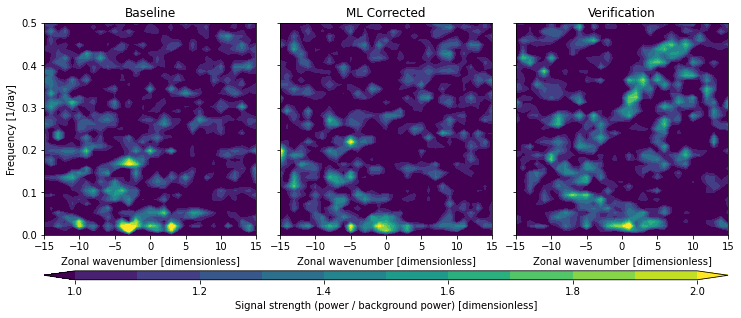

In [27]:
asym = xr.concat(asymmetric_spectra.values(), dim=pd.Index(asymmetric_spectra.keys(), name="dataset"))

fig, axes, cax = faceted.faceted(1, 3, aspect=1, width=10, cbar_mode="single", cbar_location="bottom")

for ax, dataset in zip(axes, ["baseline-precip-6hr.nc", "ml-corrected-precip-6hr.nc", "fine-res-precip-6hr.nc"]):
    p = asym.sel(dataset=dataset).plot.contourf(ax=ax, vmin=1., vmax=2, levels=11, x="wavenumber", add_colorbar=False)
    ax.set_xlim([-15, 15])
    ax.set_ylim([0, 0.5])
    ax.set_xlabel("Zonal wavenumber [dimensionless]")
    ax.set_ylabel("")
    ax.set_title(PLOT_LABELS[dataset])
    
axes[0].set_ylabel("Frequency [1/day]")
    
plt.colorbar(p, cax=cax, orientation="horizontal", label="Signal strength (power / background power) [dimensionless]")
#fig.savefig("2022-04-28-asymmetric-precipitation-wheeler-kiladis-diagram.png", bbox_inches="tight", dpi=200)

In [40]:
def tropical_mean(da):
    deep_tropics = da.sel(latitude=slice(-15, 15))
    return deep_tropics.weighted(np.cos(np.deg2rad(deep_tropics.latitude))).mean("latitude")

In [42]:
data = {
    "baseline": xr.open_dataset("baseline-precip-6hr.nc").total_precipitation_rate,
    "ml": xr.open_dataset("ml-corrected-precip-6hr.nc").total_precipitation_rate,
    "fine-res": xr.open_dataset("fine-res-precip-6hr.nc").PRATEsfc
}
means = {dataset: 86400 * tropical_mean(data[dataset]).compute() for dataset in data}

#### Hovmoller plot of precipitation between +/- 15 degrees lat

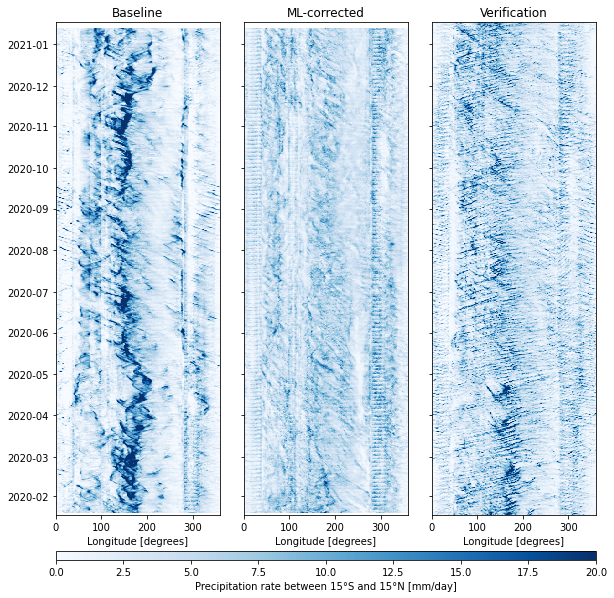

In [59]:
fig, (ax1, ax2, ax3), cax = faceted.faceted(1, 3, aspect=3., width=8, cbar_mode="single", cbar_location="bottom", cbar_pad=0.5)

means["baseline"].assign_coords(time = [vcm.cast_to_datetime(t) for t in means["baseline"].time.values]) \
    .plot(ax=ax1, y="time", add_colorbar=False, vmin=0, vmax=20, cmap="Blues")

means["ml"].assign_coords(time = [vcm.cast_to_datetime(t) for t in means["ml"].time.values]) \
    .plot(ax=ax2, y="time", add_colorbar=False, vmin=0, vmax=20, cmap="Blues")

c = means["fine-res"].assign_coords(time = [vcm.cast_to_datetime(t) for t in means["fine-res"].time.values]) \
    .plot(ax=ax3, y="time", add_colorbar=False, vmin=0, vmax=20, cmap="Blues")

ax1.set_title("Baseline")
ax2.set_title("ML-corrected")
ax3.set_title("Verification")

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("Longitude [degrees]")
    ax.set_ylabel("")
    
plt.colorbar(c, cax=cax, orientation="horizontal", label=u"Precipitation rate between 15°S and 15°N [mm/day]")
#fig.savefig("2022-04-28-hovmoller-comparison.png", bbox_inches="tight", dpi=200)

#### Mean specific humidity tendencies from ML and physics components

Previously saw in a notebook focused on the W Pacific warm pool that the nudging and physics tendencies are always in opposition to each other, with large cancellations. This is also true in general in the tropics (+\- 15 deg lat) when comparing the prognostic ML and physics humidity tendency annual average.
ML cancels out the physics tendency throughout the column, is damping variability in the tropics. This makes the mean state look better but makes simulation undershoot heavy tropical precipitation.

In [7]:
import os
import shutil
import subprocess
import sys
import tempfile

import fsspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vcm
import vcm.fv3
import xarray as xr

_KG_M2S_TO_MM_DAY = (1e3 * 86400) / 997.0
fsize=14

from dask.diagnostics import ProgressBar


In [2]:
from vcm import RegionOfInterest
import intake
from vcm.catalog import catalog

grid = catalog["grid/c48"].read()

ml_3d = intake.open_zarr("gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-09/decrease-rad-lr-updated-rad-flux-ensemble/fv3gfs_run/diags_3d.zarr").to_dask().merge(grid)

ml_state = intake.open_zarr("gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-09/decrease-rad-lr-updated-rad-flux-ensemble/fv3gfs_run/state_after_timestep.zarr").to_dask().merge(grid)
#year_mean_delp = ml_state["pressure_thickness_of_atmospheric_layer"].mean("time")

ml_3d_interp = vcm.interpolate_to_pressure_levels(
    ml_3d,  ml_state["pressure_thickness_of_atmospheric_layer"], dim="z"
)
pressure_hpa = ml_3d_interp.pressure.values/100.
ml_3d_interp = ml_3d_interp.assign_coords(pressure=pressure_hpa)

In [24]:
from cycler import cycler
import matplotlib as mpl
import fv3viz
fv3viz.use_colorblind_friendly_style()

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

colorlist = ['black']  + default_colors# [default_colors[-5], 'black', ] + default_colors


cmap = mpl.colors.ListedColormap(colorlist)
custom_cycler = cycler(color=cmap.colors,) #or simply color=colorlist



In [92]:
#wpac = RegionOfInterest(lon_bounds=(160, 180), lat_bounds=(-15, 15))
tropics = RegionOfInterest(lon_bounds=(.01, 359.9), lat_bounds=(-15, 15))
time_mean_dQ2_wpac = wpac.average(ml_3d_interp)["dQ2"].mean("time").load()
time_mean_pQ2_wpac = wpac.average(ml_3d_interp)["tendency_of_specific_humidity_due_to_fv3_physics"].mean("time").load()


/home/AnnaK/miniconda3/envs/fv3net/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/AnnaK/miniconda3/envs/fv3net/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


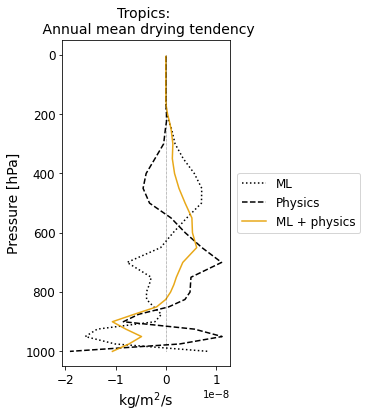

In [96]:
fig=plt.figure(figsize=(3, 6))

(-1 * time_mean_dQ2_wpac).assign_coords(pressure=pressure_hpa) \
    .plot(y="pressure",yincrease=False, label='ML', color='black', linestyle=":")# color=default_colors[4])
(-1. * time_mean_pQ2_wpac).assign_coords(pressure=pressure_hpa) \
    .plot(y="pressure",yincrease=False, label='Physics', color='black', linestyle="--")# , color=default_colors[3])

(-1 * (time_mean_pQ2_wpac + time_mean_dQ2_wpac)).assign_coords(pressure=pressure_hpa) \
    .plot(y="pressure", yincrease=False, label='ML + physics', color=default_colors[1], alpha=0.9, linestyle="-")

plt.plot([0, 0],[0, 1000],  ":", linewidth=0.5, color="black")
plt.title("Tropics: \n Annual mean drying tendency", fontsize=fsize)
plt.xlabel("kg/m$^{2}$/s", fontsize=fsize)
plt.ylabel("Pressure [hPa]", fontsize=fsize)
plt.tick_params(axis='both', labelsize=12)
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)



plt.savefig("figures/pdf/prognostic_tropics_tendency.pdf", dpi=150, bbox_inches='tight')
plt.savefig("figures/png/prognostic_tropics_tendency.png", dpi=150, bbox_inches='tight')
plt.savefig("figures/eps/prognostic_tropics_tendency.eps", format="eps", bbox_inches='tight')

In [5]:
baseline = intake.open_zarr("gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-10/baseline-seaice-prescribed/fv3gfs_run/diags.zarr").to_dask().merge(grid)
ml = intake.open_zarr("gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-09/decrease-rad-lr-updated-rad-flux-ensemble/fv3gfs_run/diags.zarr").to_dask().merge(grid)
verif = intake.open_zarr("gs://vcm-ml-intermediate/2021-10-12-PIRE-c48-post-spinup-verification/pire_atmos_phys_3h_coarse.zarr").to_dask() \
    .rename({"grid_xt": "x", "grid_yt": "y", })


#wpac = RegionOfInterest(lon_bounds=(160, 180), lat_bounds=(-15, 15))
tropics = RegionOfInterest(lon_bounds=(0, 360), lat_bounds=(-15, 15))


In [94]:
tropics = RegionOfInterest(lon_bounds=(0.1, 359.9), lat_bounds=(-15, 15))


In [6]:
baseline = baseline[["physics_precip", "total_precipitation_rate",]] \
    .resample(time="1D").mean() \
    .merge(grid).load()

ml = ml[["physics_precip", "total_precipitation_rate", "net_moistening_due_to_machine_learning"]] \
    .resample(time="1D").mean() \
    .merge(grid).load()


verif = verif[["PRATEsfc_coarse",]] \
    .resample(time="1D").mean() \
    .merge(grid).load()

#### Time series of tropical precipitation in ML-corrected run 
Again can see that the ML matches mean state well, but lacks variability.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


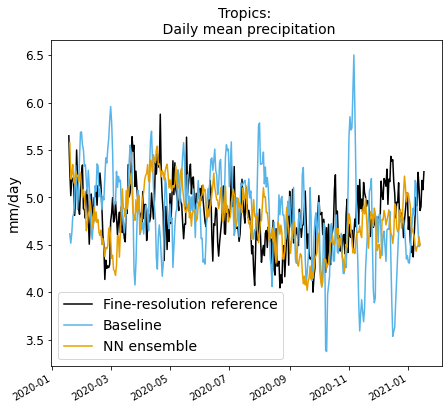

In [107]:

fig = plt.figure(figsize=(7,6))
ax = plt.gca()

ax.set_prop_cycle(custom_cycler)

(_KG_M2S_TO_MM_DAY * tropics.average(verif)["PRATEsfc_coarse"]) \
    .assign_coords(time=[vcm.cast_to_datetime(t) for t in verif.time.values]) \
    .plot(label="Fine-resolution reference")

(_KG_M2S_TO_MM_DAY * tropics.average(baseline)["total_precipitation_rate"]) \
    .assign_coords(time=[vcm.cast_to_datetime(t) for t in baseline.time.values]) \
    .plot(label="Baseline")

(_KG_M2S_TO_MM_DAY * tropics.average(ml)["total_precipitation_rate"]) \
    .assign_coords(time=[vcm.cast_to_datetime(t) for t in ml.time.values]) \
    .plot(label="NN ensemble")
ax.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=fsize)
plt.xlabel("")
plt.ylabel("mm/day", fontsize=fsize)
#plt.ylim(0, 32)
plt.title("Tropics: \n Daily mean precipitation", fontsize=fsize)


plt.savefig("figures/pdf/prognostic_tropics_precip.pdf", dpi=150, bbox_inches='tight')
plt.savefig("figures/png/prognostic_tropics_precip.png", dpi=150, bbox_inches='tight')
plt.savefig("figures/eps/prognostic_tropics_precip.eps", format="eps", bbox_inches='tight')

#### Daily precipitation rate PDF

PIRE physics output was interval average over 3 hr window, our outputs are snapshots. Use daily mean for pdf.



In [20]:

grid = catalog["grid/c48"].read()

ml_precip = intake.open_zarr("gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-09/decrease-rad-lr-updated-rad-flux-ensemble/fv3gfs_run/diags.zarr").to_dask() \
    .resample(time="1D").mean()["total_precipitation_rate"]
baseline_precip = intake.open_zarr("gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-10/baseline-seaice-prescribed/fv3gfs_run/diags.zarr").to_dask() \
    .resample(time="1D").mean()["total_precipitation_rate"]
verif_precip = catalog["2020_1yr_pire_physics"].to_dask() \
    .resample(time="1D").mean() \
    .rename({"PRATEsfc_coarse": "total_precipitation_rate"})["total_precipitation_rate"] \
    .rename({"grid_xt": "x", "grid_yt": "y"})

KeyboardInterrupt: 

In [26]:
varname="total_precipitation_rate"
histograms = {}
for ds_, label in zip([verif_precip, baseline_precip, ml_precip], ["Fine-resolution reference", "Baseline", "ML-corrected"]):
    counts = xr.Dataset()
    count, width = vcm.histogram(
        ds_  * _KG_M2S_TO_MM_DAY, bins= np.logspace(-1, np.log10(500), 101), density=True
    )
    counts[varname] = count
    counts[f"{varname}_bin_width"] = width
    histograms[label] = counts
    #counts["total_precipitation_rate"].plot(label=label)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


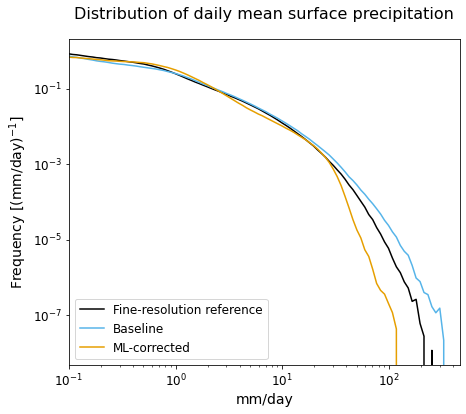

In [34]:

fig = plt.figure(figsize=(7,6))
ax = plt.gca()

ax.set_prop_cycle(custom_cycler)

for label, hist in histograms.items():
    hist["total_precipitation_rate"].plot(label=label)


plt.xlim(hist.total_precipitation_rate_bins.min(), hist.total_precipitation_rate_bins.max())
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12, loc='lower left')

plt.tick_params(axis='both', labelsize=12)

plt.title("Distribution of daily mean surface precipitation", fontsize=fsize+2, pad=20)
    
plt.xlabel("mm/day", fontsize=fsize)
plt.ylabel('Frequency [(mm/day)$^{-1}$]', fontsize=fsize)



plt.savefig("figures/pdf/prognostic_precip_pdf.pdf", dpi=150, bbox_inches='tight')
plt.savefig("figures/png/prognostic_precip_pdf.png", dpi=150, bbox_inches='tight')
plt.savefig("figures/eps/prognostic_precip_pdf.eps", format="eps", bbox_inches='tight')

In [19]:
varname="total_precipitation_rate"
histograms_tropics = {}
for ds_, label in zip([verif_precip, baseline_precip, ml_precip], ["Fine-resolution reference", "Baseline", "ML-corrected"]):
    counts = xr.Dataset()
    count, width = vcm.histogram(
        ds_.where(grid.lat < 15).where(grid.lat>-15)  * _KG_M2S_TO_MM_DAY, bins= np.logspace(-1, np.log10(500), 101), density=True
    )
    counts[varname] = count
    counts[f"{varname}_bin_width"] = width
    histograms_tropics[label] = counts
    #counts["total_precipitation_rate"].plot(label=label)

Text(0, 0.5, 'Frequency [(mm/day)$^{-1}$]')

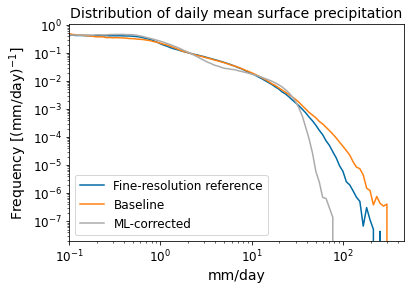

In [21]:
for label, hist in histograms_tropics.items():
    hist["total_precipitation_rate"].plot(label=label)


plt.xlim(hist.total_precipitation_rate_bins.min(), hist.total_precipitation_rate_bins.max())
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12, loc='lower left')

plt.tick_params(axis='both', labelsize=12)

plt.title("Distribution of daily mean surface precipitation", fontsize=fsize)
    
plt.xlabel("mm/day", fontsize=fsize)
plt.ylabel('Frequency [(mm/day)$^{-1}$]', fontsize=fsize)
